# PREDICTING RSA CLUSTER LABELS

This notebook uses ANN and KNN to predict RSA cluster labels. In here, we try 50 models from 10 different seeds and chose the best according to validation accuracy and loss. Moreover, we perform 10 repeat 10-fold cross validation to ensure the model works well across a range of different training data folds.

## IMPORTING NECESSARY PACKAGES

In [2]:
from fragsys_ml import *

2023-11-28 15:21:54.896409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## READING INPUT DATA

In [3]:
main_dir = "./../"
results_dir = os.path.join(main_dir, "results")
figs_dir = os.path.join(main_dir, "figs")

In [4]:
rsa_cluster_dict = load_pickle(os.path.join(results_dir, "rsa_cluster_dict.pkl"))
cluster_membership = load_pickle(os.path.join(results_dir, "rsa_cluster_membership.pkl"))
rsa_profs = load_pickle(os.path.join(results_dir, "rsa_profs.pkl"))
ud_mat = pd.read_pickle(os.path.join(results_dir, "UD_df.pkl"))

## CREATING FEATURE DATAFRAME

In [4]:
max_len = max([len(v) for v in rsa_profs.values()])
bs_vectors = []
bs_vectors_dict = {}
for bs_id, rsa_sig in rsa_profs.items():
    rsa_sig_len = len(rsa_sig)
    rsa_range_prop = [0 for i in range(10)] # now let us change to 10
    for rsa in rsa_sig:
        prop_i = int(rsa/10) # 10 RSA BINS: b1 = [0,10), b2 = [10, 20), ... b10 = [90, MAX)
        if prop_i > 9: # if greater than 100, put in 10th bin
            prop_i = 9
        #print(prop_i)
        rsa_range_prop[prop_i] += 1
    rsa_range_prop = [round(i/rsa_sig_len, 3) for i in rsa_range_prop]
    rsa_range_prop.insert(0, rsa_sig_len/max_len) # ADDING BINDING SITE SIZE RELATIVE TO MAX SITE SIZE (IN THIS CASE 40)
    bs_vectors.append(rsa_range_prop)
    bs_vectors_dict[bs_id] = rsa_range_prop
    
vector_df = pd.DataFrame(bs_vectors, index = list(rsa_profs.keys())) # obtaining RSA vectors, which are the 11-element features used for the machine learning

In [5]:
vector_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10
H0Y4R8_0_BS0,0.150,0.000,0.000,0.167,0.167,0.333,0.000,0.167,0.167,0.0,0.0
O43809_0_BS0,0.600,0.375,0.250,0.083,0.167,0.042,0.042,0.000,0.042,0.0,0.0
O43809_0_BS1,0.325,0.231,0.077,0.231,0.077,0.077,0.077,0.077,0.154,0.0,0.0


In [6]:
vector_df.shape

(293, 11)

In [8]:
vector_df.to_pickle(os.path.join(results_dir, "rsa_vectors.pkl"))

In [7]:
label_df = pd.DataFrame.from_dict(rsa_cluster_dict, orient = "index", columns = ["label"])

In [19]:
label_df = label_df - 1

In [20]:
round(label_df.label.value_counts().sort_index()/len(label_df),2)

0    0.16
1    0.43
2    0.31
3    0.10
Name: label, dtype: float64

In [21]:
label_df.head(3)

,label
H0Y4R8_0_BS0,3
O43809_0_BS0,0
O43809_0_BS1,1


In [22]:
label_df.shape

(293, 1)

## CREATE MODEL

In [23]:
X = vector_df.sort_index() # here, X is still a dataframe. Thus, we maintain binding site IDs
y = label_df.sort_index()    # here, y is still a list

#### DATA SPLIT IN MODEL (10/11) (USED FOR TRAINING) AND BLIND (USED FOR FINAL TESTING) (1/11) STRATIFYING BY CLUSTER LABEL, SO THEY ARE BALANCED

In [24]:
X_model, X_blind, y_model, y_blind = train_test_split(X, y, test_size = 0.091, random_state = 12345, shuffle = True, stratify = y) ### X_blind and y_blind will be the blind test at the end

In [23]:
dump_pickle(X_model.index.tolist(), os.path.join(results_dir, "X_model.pkl"))

In [25]:
y_model.head(3)

,label
P47811_0_BS1,1
P0DTD1_0_BS23,1
Q96HY7_0_BS0,1


#### CLASSES ARE IMBALANCED DUE TO OUR TRAINING DATASET, BUT BOTH TRAINING AND TEST DATA HAVE THE SAME PROPORTION FOR EACH CLASS

In [26]:
print(len(X_model))
print(len(X_blind))
print(len(y_model))
print(len(y_blind))
for el in [0,1,2,3]:
    print(el, round(y_model.label.tolist().count(el)/len(y_model),2))
for el in [0,1,2,3]:
    print(el, round(y_blind.label.tolist().count(el)/len(y_blind),2))

266
27
266
27
0 0.16
1 0.43
2 0.31
3 0.1
0 0.15
1 0.44
2 0.3
3 0.11


#### CALLBACK TO GET BEST MODEL DURING TRAINING

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 100, verbose = 1, mode = 'max', restore_best_weights = True)

#### OBTAINING CLASS WEIGHTS TO MINIMISE EFFECT OF CLASS IMBALANCE IN TRAINING DATASET

In [27]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_model.label.tolist()),
                                                 y = np.array(y_model.label))
class_weights_dict = {i: class_weights[i] for i in np.unique(y_model)}

In [28]:
class_weights

array([1.58333333, 0.57826087, 0.80120482, 2.55769231])

#### THE WEIGHT FOR EACH CLASS IS INVERSELY PROPORTIONAL TO THEIR FREQUENCY IN THE DATA SET

In [29]:
for k, v in class_weights_dict.items():
    print(k, round(v, 2))

0 1.58
1 0.58
2 0.8
3 2.56


#### DATA SPLIT IN MODEL_TRAIN (0.8) (USED FOR MODEL TRAINING) AND MODEL_VAL (0.2) (USED FOR MODEL VALIDATION DURING TRAINING) STRATIFYING BY CLUSTER LABEL, SO THEY ARE BALANCED

In [30]:
X_model_train, X_model_val, y_model_train, y_model_val = train_test_split(X_model, y_model, test_size = 0.2, random_state = 12345, shuffle = True, stratify = y_model)

In [31]:
len(set(X_model_train.index.tolist()).intersection(set(y_model_train.index.tolist())))/len(y_model_train)

1.0

In [32]:
len(set(X_model_val.index.tolist()).intersection(set(y_model_val.index.tolist())))/len(y_model_val)

1.0

#### TRAINING AND VALIDATION DATA HAVE THE SAME PROPORTION FOR EACH CLASS

In [33]:
print(len(X_model_train))
print(len(X_model_val))
print(len(y_model_train))
print(len(y_model_val))
for el in [0,1,2,3]:
    print(el, round(y_model_train.label.tolist().count(el)/len(y_model_train),2))
for el in [0,1,2,3]:
    print(el, round(y_model_val.label.tolist().count(el)/len(y_model_val),2))

212
54
212
54
0 0.16
1 0.43
2 0.31
3 0.1
0 0.17
1 0.43
2 0.31
3 0.09


# TRAINING

In [34]:
random.seed(1)

In [25]:
seeds = [random.randint(1, 100000) for i in range(10)] # [90015, 88091, 30338, 35897, 58161, 3551, 97160, 85734, 92233, 99814]

In [26]:
print(seeds) #[17612, 74607, 8272, 33433, 15456, 64938, 99741, 58916, 61899, 85406]

[17612, 74607, 8272, 33433, 15456, 64938, 99741, 58916, 61899, 85406]


In [35]:
seeds = [17612, 74607, 8272, 33433, 15456, 64938, 99741, 58916, 61899, 85406]

In [36]:
initializer = tf.keras.initializers.GlorotUniform(seed = 3551)

In [37]:
X_model_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10
P0DTD1_2_BS0,0.550,0.136,0.227,0.045,0.182,0.091,0.000,0.136,0.045,0.091,0.045
Q6PJP8_0_BS9,0.175,0.000,0.000,0.429,0.143,0.000,0.000,0.286,0.143,0.000,0.000
Q8IU60_0_BS0,0.300,0.333,0.000,0.167,0.250,0.083,0.083,0.000,0.000,0.000,0.083


### USING 10 DIFFERENT SEEDS, AND 50 MODELS WITHIN EACH SEED TO SELECT BEST MODEL

In [31]:
wd = os.path.join(main_dir, "/ANN_results/diff_seeds") # diff_seeds will be ward now
os.mkdir(wd)
for seed in seeds:
    print("STARTING SEED {}".format(seed))
    seed_dir = os.path.join(wd, str(seed))
    mods_dir = os.path.join(seed_dir, "models")
    hist_dir = os.path.join(seed_dir, "hists")
    os.mkdir(seed_dir)
    os.mkdir(mods_dir)
    os.mkdir(hist_dir)
    
    initializer_seed = tf.keras.initializers.GlorotUniform(seed = seed)
    for i in range(50):
        print(i+1)
        
        model_i = Sequential([
            Dense(units = 10, input_shape=(11,), activation = "relu", kernel_initializer = initializer_seed), # THIS IS THE MODEL
            Dense(units = 4, activation = "softmax", kernel_initializer = initializer_seed)
        ])
        
        model_i.compile(optimizer=Adam(learning_rate=0.01), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"]) # COMPILE MODEL
        
        hist_i = model_i.fit(
            x = X_model_train, y = y_model_train, batch_size = 32,
            callbacks = [callback], validation_data = (X_model_val, y_model_val),
            epochs = 300, shuffle = True, verbose = 0, class_weight =  class_weights_dict # TRAIN MODEL
        )
        final_epoch = callback.stopped_epoch-100
        if final_epoch == -100:
            final_epoch = 299
        final_acc = round(hist_i.history["val_accuracy"][final_epoch],2)
        
        model_i.save(os.path.join(mods_dir, "{}_{}_model_epoch_{}_train_acc_{}.h5".format(seed, i, final_epoch, round(final_acc, 2)))) # SAVING MODEL
        
        pd.DataFrame(hist_i.history).to_csv(os.path.join(hist_dir, "{}_{}_hist_epoch_{}_train_acc_{}.csv".format(seed, i, final_epoch, round(final_acc, 2))), index = False) # SAVING TRAINING DF

STARTING SEED 17612
1


2023-05-04 11:32:15.359949: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 111.
Epoch 211: early stopping
2
Restoring model weights from the end of the best epoch: 87.
Epoch 187: early stopping
3
Restoring model weights from the end of the best epoch: 86.
Epoch 186: early stopping
4
Restoring model weights from the end of the best epoch: 83.
Epoch 183: early stopping
5
Restoring model weights from the end of the best epoch: 76.
Epoch 176: early stopping
6
Restoring model weights from the end of the best epoch: 91.
Epoch 191: early stopping
7
Restoring model weights from the end of the best epoch: 101.
Epoch 201: early stopping
8
Restoring model weights from the end of the best epoch: 99.
Epoch 199: early stopping
9
Restoring model weights from the end of the best epoch: 96.
Epoch 196: early stopping
10
Restoring model weights from the end of the best epoch: 101.
Epoch 201: early stopping
11
Restoring model weights from the end of the best epoch: 122.
Epoch 222: early stopping
12
Restoring model weights f

## REPEATED STRATIFIED K-FOLD CROSS-VALIDATION

In [43]:
rskf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10, random_state = 312) #sets are one after other. 0-10, is one 10-fold CV, 10-20, and so on

In [33]:
accs_pred_ANN = [] # prediction accuracies by ANN
accs_pred_KNN = [] # prediction accuracies by KNN

accs_rand = [] # prediction accuracies at random (randomly assigning a cluster label p=0.25 each)

accs_pred_ANN_rand = [] # prediction accuracies of randomly trained ANN
accs_pred_KNN_rand = [] # prediction accuracies of randomly trained KNN

knn = KNeighborsClassifier(n_neighbors=3) # starting KNN classifier

ann_good_preds = [] # predictions by ANN
ann_good_preds_round = [] # rounded predictions by ANN
ann_real_vals = [] # real labels
ann_rand_preds = [] # predictions by randomly trained ANN
ann_rand_preds_round = [] # rounded predictions of randomly trained ANN
#ann_


cv_dir = "./results/ANN_results/cv"
os.mkdir(cv_dir)
cv_good_dir = os.path.join(cv_dir, "good")
cv_rand_dir = os.path.join(cv_dir, "rand")
os.mkdir(cv_good_dir)
os.mkdir(cv_rand_dir)
os.mkdir(os.path.join(cv_good_dir, "hists"))
os.mkdir(os.path.join(cv_good_dir, "mods"))
os.mkdir(os.path.join(cv_rand_dir, "hists"))
os.mkdir(os.path.join(cv_rand_dir, "mods"))

for i, (train_idx, val_idx) in enumerate(rskf.split(X_model, y_model)):
    
    seed = 3551
    seed1 = random.randint(1, 1000000000)
    seed2 = random.randint(1, 1000000000)
    #seed1 = 426359796
    #seed2 = 44036644
    print(seed1, seed2)
    
    bs_ids_train = X_model.index[train_idx].tolist() # THESE IDS WILL SUBSET BOTH DATASETS IN THE SAME WAY (INPUT FOR KNN AND INPUT FOR ANN)
    bs_ids_val = X_model.index[val_idx].tolist() # THESE IDS WILL SUBSET BOTH DATASETS IN THE SAME WAY (INPUT FOR KNN AND INPUT FOR ANN)
    
    X_train_ANN = X_model.loc[bs_ids_train, :]
    y_train_ANN = y_model.loc[bs_ids_train, :]
    
    X_train_ANN_rand = randomise(X_train_ANN, seed1)     # THIS WILL BE USED TO TRAIN ANN WITH RANDOMLY SHUFFLED TRAINING DATA
    y_train_ANN_rand = randomise(y_train_ANN, seed2)     # THIS WILL BE USED TO TRAIN ANN WITH RANDOMLY SHUFFLED TRAINING DATA
    
    X_val_ANN = X_model.loc[bs_ids_val, :]
    y_val_ANN = y_model.loc[bs_ids_val, :]
    
    X_train_KNN = ud_mat.loc[bs_ids_train, bs_ids_train]
    y_train_KNN = y_model.loc[bs_ids_train, :]
    
    X_train_KNN_rand = randomise(X_train_KNN, seed1)     # THIS WILL BE USED TO TRAIN KNN WITH RANDOMLY SHUFFLED TRAINING DATA
    y_train_KNN_rand = randomise(y_train_KNN, seed2)     # THIS WILL BE USED TO TRAIN KNN WITH RANDOMLY SHUFFLED TRAINING DATA
    
    X_val_KNN = ud_mat.loc[bs_ids_val, bs_ids_train]
    y_val_KNN = y_model.loc[bs_ids_val, :]
    
    #break
    
    ### PREDICTING WITH ANN ### well trained model
    
    X_model_train_ANN, X_model_val_ANN, y_model_train_ANN, y_model_val_ANN = train_test_split(
        X_train_ANN, y_train_ANN, test_size = 0.2, random_state = 12345,
        shuffle = True, stratify = y_train_ANN
    )
    
    class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train_ANN.label.tolist()),
                                                 y = np.array(y_train_ANN.label))
    
    class_weights_dict = {i: class_weights[i] for i in np.unique(y_train_ANN.label.tolist())}
    
    cv_model = Sequential([
        Dense(units = 10, input_shape=(11,), activation = "relu", kernel_initializer = initializer),
        Dense(units = 4, activation = "softmax", kernel_initializer = initializer)
    ])
    
    cv_model.compile(optimizer=Adam(learning_rate=0.01), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
    
    hist_cv_model = cv_model.fit(
        x = X_model_train_ANN, y = y_model_train_ANN, batch_size = 32,
        callbacks=[callback], validation_data = (X_model_val_ANN, y_model_val_ANN),
        epochs = 300, shuffle = True, verbose = 0, class_weight =  class_weights_dict
    )
    
    predictions = cv_model.predict(x = X_val_ANN, batch_size = 32, verbose = 0)
    rounded_predictions = np.argmax(predictions, axis = -1)
    CalculatedAccuracy = sum(rounded_predictions == y_val_ANN.label.tolist())/len(rounded_predictions)
    accs_pred_ANN.append(CalculatedAccuracy)
    ann_good_preds.append(predictions)
    ann_good_preds_round.append(rounded_predictions)
    ann_real_vals.append(y_val_ANN)
    
    final_epoch_good = callback.stopped_epoch-100
    if final_epoch_good == -100:
        final_epoch_good = 299
    final_acc_good = round(hist_cv_model.history["val_accuracy"][final_epoch_good],2)
        

    cv_model.save(os.path.join(cv_dir, "good", "mods", "{}_{}_good_model_epoch_{}_train_acc_{}.h5".format(seed, i, final_epoch_good, round(final_acc_good, 2))))
        
    pd.DataFrame(hist_cv_model.history).to_csv(os.path.join(cv_dir, "good", "hists", "{}_{}_good_hist_epoch_{}_train_acc_{}.csv".format(seed, i, final_epoch_good, round(final_acc_good, 2))), index = False)
        
        
        
    ### PREDICTING WITH ANN ### RANDOMLY trained model
    
    X_model_train_ANN_rand, X_model_val_ANN_rand, y_model_train_ANN_rand, y_model_val_ANN_rand = train_test_split(
        X_train_ANN_rand, y_train_ANN_rand, test_size = 0.2, random_state = 12345,
        shuffle = True, stratify = y_train_ANN_rand
    )
    
    class_weights_rand = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train_ANN_rand.label.tolist()),
                                                 y = np.array(y_train_ANN_rand.label))
    
    class_weights_dict_rand = {i: class_weights_rand[i] for i in np.unique(y_train_ANN_rand.label.tolist())}
    
    cv_model_rand = Sequential([
        Dense(units = 10, input_shape=(11,), activation = "relu", kernel_initializer = initializer),
        Dense(units = 4, activation = "softmax", kernel_initializer = initializer)
    ])
    
    cv_model_rand.compile(optimizer=Adam(learning_rate=0.01), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
    
    hist_cv_model_rand = cv_model_rand.fit(
        x = X_model_train_ANN_rand, y = y_model_train_ANN_rand, batch_size = 32,
        callbacks=[callback], validation_data = (X_model_val_ANN_rand, y_model_val_ANN_rand),
        epochs = 300, shuffle = True, verbose = 0, class_weight =  class_weights_dict_rand
    )
    
    predictions_rand = cv_model_rand.predict(x = X_val_ANN, batch_size = 32, verbose = 0)
    rounded_predictions_rand = np.argmax(predictions_rand, axis = -1)
    CalculatedAccuracy_rand = sum(rounded_predictions_rand == y_val_ANN.label.tolist())/len(rounded_predictions_rand)
    accs_pred_ANN_rand.append(CalculatedAccuracy_rand)
    ann_rand_preds.append(predictions_rand)
    ann_rand_preds_round.append(rounded_predictions_rand)
    
    final_epoch_rand = callback.stopped_epoch-100
    if final_epoch_rand == -100:
        final_epoch_rand = 299
    final_acc_rand = round(hist_cv_model_rand.history["val_accuracy"][final_epoch_rand],2)
        

    cv_model_rand.save(os.path.join(cv_dir, "rand", "mods", "{}_{}_rand_model_epoch_{}_train_acc_{}.h5".format(seed, i, final_epoch_rand, round(final_acc_rand, 2))))
        
    pd.DataFrame(hist_cv_model_rand.history).to_csv(os.path.join(cv_dir, "rand", "hists", "{}_{}_rand_hist_epoch_{}_train_acc_{}.csv".format(seed, i, final_epoch_rand, round(final_acc_rand, 2))), index = False)
    
    
    ### PREDICTING WITH KNN ### with well trained model
    
    knn.fit(X_train_KNN, y_train_KNN) # train the model using the real training set

    y_pred_KNN = knn.predict(X_val_KNN) # predict the response for test dataset

    acc_pred = metrics.accuracy_score(y_val_KNN, y_pred_KNN) # accuracies of well trained KNN prediction

    accs_pred_KNN.append(acc_pred)
    
    ### PREDICTING WITH KNN ### with RANDOMLY trained model

    knn.fit(X_train_KNN_rand, y_train_KNN_rand) # train the model using the randomised training set

    y_pred_KNN_rand = knn.predict(X_val_KNN) # predict the response for test dataset
    
    acc_pred_rand = metrics.accuracy_score(y_val_KNN, y_pred_KNN_rand) # accuracies of randomly trained KNN prediction
    
    accs_pred_KNN_rand.append(acc_pred_rand)
    
    ### COMPLETELY RANDOM BASELINE PREDICTION ### 
    
    y_rand = [random.randint(0, 3) for i in range(len(y_val_KNN))] # assigning random cluster labels p=0.25
    
    acc_rand = metrics.accuracy_score(y_val_KNN, y_rand)
    
    accs_rand.append(acc_rand)
    
    #break

407608742 846885254
Restoring model weights from the end of the best epoch: 55.
Epoch 155: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 105: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


183701140 349994786
Restoring model weights from the end of the best epoch: 116.
Epoch 216: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


908039949 885569339
Restoring model weights from the end of the best epoch: 98.
Epoch 198: early stopping
Restoring model weights from the end of the best epoch: 9.
Epoch 109: early stopping
282018763 845638329


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 102.
Epoch 202: early stopping
Restoring model weights from the end of the best epoch: 125.
Epoch 225: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


563996155 917752611
Restoring model weights from the end of the best epoch: 45.
Epoch 145: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


68695501 175890095
Restoring model weights from the end of the best epoch: 87.
Epoch 187: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


49681948 569342736
Restoring model weights from the end of the best epoch: 57.
Epoch 157: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


354604014 565155716
Restoring model weights from the end of the best epoch: 18.
Epoch 118: early stopping
Restoring model weights from the end of the best epoch: 25.
Epoch 125: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


664514255 433810804
Restoring model weights from the end of the best epoch: 89.
Epoch 189: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 105: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


688457249 702267265
Restoring model weights from the end of the best epoch: 37.
Epoch 137: early stopping
Restoring model weights from the end of the best epoch: 18.
Epoch 118: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


854912041 195077705
Restoring model weights from the end of the best epoch: 89.
Epoch 189: early stopping
Restoring model weights from the end of the best epoch: 183.
Epoch 283: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


17679896 228810485
Restoring model weights from the end of the best epoch: 52.
Epoch 152: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


742827526 961371674
Restoring model weights from the end of the best epoch: 29.
Epoch 129: early stopping
Restoring model weights from the end of the best epoch: 69.
Epoch 169: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


670278442 35874491
Restoring model weights from the end of the best epoch: 75.
Epoch 175: early stopping
Restoring model weights from the end of the best epoch: 86.
Epoch 186: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


633135123 652010711
Restoring model weights from the end of the best epoch: 43.
Epoch 143: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


450170541 584435019
Restoring model weights from the end of the best epoch: 58.
Epoch 158: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


751893203 140951099
Restoring model weights from the end of the best epoch: 121.
Epoch 221: early stopping
Restoring model weights from the end of the best epoch: 45.
Epoch 145: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


841883367 46166933
Restoring model weights from the end of the best epoch: 80.
Epoch 180: early stopping
Restoring model weights from the end of the best epoch: 32.
Epoch 132: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


252796019 779059939
Restoring model weights from the end of the best epoch: 57.
Epoch 157: early stopping
Restoring model weights from the end of the best epoch: 41.
Epoch 141: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


992641751 580601684
Restoring model weights from the end of the best epoch: 44.
Epoch 144: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


89266177 965280829
Restoring model weights from the end of the best epoch: 26.
Epoch 126: early stopping
Restoring model weights from the end of the best epoch: 81.
Epoch 181: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


109602386 585942742
Restoring model weights from the end of the best epoch: 177.
Epoch 277: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


206255673 818138888
Restoring model weights from the end of the best epoch: 199.
Epoch 299: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


523171552 953089310
Restoring model weights from the end of the best epoch: 52.
Epoch 152: early stopping
Restoring model weights from the end of the best epoch: 115.
Epoch 215: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


631970593 559626635
Restoring model weights from the end of the best epoch: 83.
Epoch 183: early stopping
Restoring model weights from the end of the best epoch: 15.
Epoch 115: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


390146467 61063090
Restoring model weights from the end of the best epoch: 62.
Epoch 162: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


735749473 629257394
Restoring model weights from the end of the best epoch: 173.
Epoch 273: early stopping
Restoring model weights from the end of the best epoch: 59.
Epoch 159: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


738545213 488941273
Restoring model weights from the end of the best epoch: 23.
Epoch 123: early stopping
Restoring model weights from the end of the best epoch: 84.
Epoch 184: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


101540424 520394506
Restoring model weights from the end of the best epoch: 121.
Epoch 221: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 105: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


974973459 354562266
Restoring model weights from the end of the best epoch: 50.
Epoch 150: early stopping
Restoring model weights from the end of the best epoch: 22.
Epoch 122: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


883005844 186886115
Restoring model weights from the end of the best epoch: 28.
Epoch 128: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 107: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


484503997 386486896
Restoring model weights from the end of the best epoch: 76.
Epoch 176: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


610434092 446924464
Restoring model weights from the end of the best epoch: 68.
Epoch 168: early stopping
Restoring model weights from the end of the best epoch: 47.
Epoch 147: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


587727316 890889307
Restoring model weights from the end of the best epoch: 83.
Epoch 183: early stopping
Restoring model weights from the end of the best epoch: 24.
Epoch 124: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


549070142 187317422
Restoring model weights from the end of the best epoch: 100.
Epoch 200: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


429311612 883743910
Restoring model weights from the end of the best epoch: 46.
Epoch 146: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


948100736 460771
Restoring model weights from the end of the best epoch: 80.
Epoch 180: early stopping
Restoring model weights from the end of the best epoch: 131.
Epoch 231: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


395401385 710527062
Restoring model weights from the end of the best epoch: 68.
Epoch 168: early stopping
Restoring model weights from the end of the best epoch: 21.
Epoch 121: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


502551167 454342498
Restoring model weights from the end of the best epoch: 116.
Epoch 216: early stopping
Restoring model weights from the end of the best epoch: 20.
Epoch 120: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


981128662 998954465
Restoring model weights from the end of the best epoch: 65.
Epoch 165: early stopping
Restoring model weights from the end of the best epoch: 55.
Epoch 155: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


607048393 968295627
Restoring model weights from the end of the best epoch: 70.
Epoch 170: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 106: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


508417272 861343587
Restoring model weights from the end of the best epoch: 42.
Epoch 142: early stopping
Restoring model weights from the end of the best epoch: 11.
Epoch 111: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


568592548 813795908
Restoring model weights from the end of the best epoch: 97.
Epoch 197: early stopping
Restoring model weights from the end of the best epoch: 117.
Epoch 217: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


639027793 215615208
Restoring model weights from the end of the best epoch: 161.
Epoch 261: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


579852931 993292572
Restoring model weights from the end of the best epoch: 34.
Epoch 134: early stopping
Restoring model weights from the end of the best epoch: 22.
Epoch 122: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


622695651 602332857
Restoring model weights from the end of the best epoch: 60.
Epoch 160: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


908765602 630038878
Restoring model weights from the end of the best epoch: 163.
Epoch 263: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


352636678 903162768
Restoring model weights from the end of the best epoch: 90.
Epoch 190: early stopping
Restoring model weights from the end of the best epoch: 118.
Epoch 218: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


822177140 943670640
Restoring model weights from the end of the best epoch: 85.
Epoch 185: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 108: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


663432513 730934710
Restoring model weights from the end of the best epoch: 119.
Epoch 219: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 105: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


589468421 476728924
Restoring model weights from the end of the best epoch: 33.
Epoch 133: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


349123635 332050498
Restoring model weights from the end of the best epoch: 84.
Epoch 184: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


439274144 726366381
Restoring model weights from the end of the best epoch: 88.
Epoch 188: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 108: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


86374155 289752917
Restoring model weights from the end of the best epoch: 173.
Epoch 273: early stopping
Restoring model weights from the end of the best epoch: 72.
Epoch 172: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


781585331 603685681
Restoring model weights from the end of the best epoch: 35.
Epoch 135: early stopping
Restoring model weights from the end of the best epoch: 98.
Epoch 198: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


769086484 680489811
Restoring model weights from the end of the best epoch: 121.
Epoch 221: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


396702087 161262102
Restoring model weights from the end of the best epoch: 104.
Epoch 204: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 104: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


132852798 370963958
Restoring model weights from the end of the best epoch: 33.
Epoch 133: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 105: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


550790803 869278599
Restoring model weights from the end of the best epoch: 49.
Epoch 149: early stopping
Restoring model weights from the end of the best epoch: 61.
Epoch 161: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


21130878 863933266
Restoring model weights from the end of the best epoch: 78.
Epoch 178: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


539142270 564663340
Restoring model weights from the end of the best epoch: 103.
Epoch 203: early stopping
Restoring model weights from the end of the best epoch: 30.
Epoch 130: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


866932337 62649478
Restoring model weights from the end of the best epoch: 94.
Epoch 194: early stopping
Restoring model weights from the end of the best epoch: 127.
Epoch 227: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


674940257 280709802
Restoring model weights from the end of the best epoch: 123.
Epoch 223: early stopping
Restoring model weights from the end of the best epoch: 16.
Epoch 116: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


496042818 925934020
Restoring model weights from the end of the best epoch: 4.
Epoch 104: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


349076223 185661442
Restoring model weights from the end of the best epoch: 33.
Epoch 133: early stopping
Restoring model weights from the end of the best epoch: 26.
Epoch 126: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


29223132 370207204
Restoring model weights from the end of the best epoch: 66.
Epoch 166: early stopping
Restoring model weights from the end of the best epoch: 49.
Epoch 149: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


311219788 519198252
Restoring model weights from the end of the best epoch: 112.
Epoch 212: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


948283665 511030943
Restoring model weights from the end of the best epoch: 73.
Epoch 173: early stopping
Restoring model weights from the end of the best epoch: 19.
Epoch 119: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


968633931 321295420
Restoring model weights from the end of the best epoch: 38.
Epoch 138: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


840900816 752295881
Restoring model weights from the end of the best epoch: 25.
Epoch 125: early stopping
Restoring model weights from the end of the best epoch: 34.
Epoch 134: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


864239962 29567246
Restoring model weights from the end of the best epoch: 111.
Epoch 211: early stopping
Restoring model weights from the end of the best epoch: 19.
Epoch 119: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


491366947 893472967
Restoring model weights from the end of the best epoch: 38.
Epoch 138: early stopping
Restoring model weights from the end of the best epoch: 66.
Epoch 166: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


788791699 432987958
Restoring model weights from the end of the best epoch: 107.
Epoch 207: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


91793918 320717270
Restoring model weights from the end of the best epoch: 70.
Epoch 170: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 108: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


575069389 321729365
Restoring model weights from the end of the best epoch: 60.
Epoch 160: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 105: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


224246543 292204982
Restoring model weights from the end of the best epoch: 78.
Epoch 178: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


843068497 861752175
Restoring model weights from the end of the best epoch: 61.
Epoch 161: early stopping
Restoring model weights from the end of the best epoch: 38.
Epoch 138: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


855275381 189617827
Restoring model weights from the end of the best epoch: 43.
Epoch 143: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


998290746 715730228
Restoring model weights from the end of the best epoch: 29.
Epoch 129: early stopping
Restoring model weights from the end of the best epoch: 48.
Epoch 148: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


211921106 459406505
Restoring model weights from the end of the best epoch: 54.
Epoch 154: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


935005515 715384610
Restoring model weights from the end of the best epoch: 58.
Epoch 158: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 105: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


960345191 820225877
Restoring model weights from the end of the best epoch: 22.
Epoch 122: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 110: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


241607355 131881365
Restoring model weights from the end of the best epoch: 100.
Epoch 200: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


367664062 186355225
Restoring model weights from the end of the best epoch: 185.
Epoch 285: early stopping
Restoring model weights from the end of the best epoch: 18.
Epoch 118: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


316556474 159671628
Restoring model weights from the end of the best epoch: 122.
Epoch 222: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


942584530 375751675
Restoring model weights from the end of the best epoch: 34.
Epoch 134: early stopping
Restoring model weights from the end of the best epoch: 62.
Epoch 162: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


799775892 146308714
Restoring model weights from the end of the best epoch: 43.
Epoch 143: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


669912629 786788262
Restoring model weights from the end of the best epoch: 91.
Epoch 191: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


667314760 3984726
Restoring model weights from the end of the best epoch: 52.
Epoch 152: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


238708286 79314428
Restoring model weights from the end of the best epoch: 52.
Epoch 152: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 110: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


743560711 628762378
Restoring model weights from the end of the best epoch: 78.
Epoch 178: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 106: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


595787225 564857751
Restoring model weights from the end of the best epoch: 48.
Epoch 148: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


399969524 774108247
Restoring model weights from the end of the best epoch: 68.
Epoch 168: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


394122716 897140262
Restoring model weights from the end of the best epoch: 68.
Epoch 168: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


90046103 135601694
Restoring model weights from the end of the best epoch: 69.
Epoch 169: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


750557520 42284989
Restoring model weights from the end of the best epoch: 37.
Epoch 137: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


549186711 378720085
Restoring model weights from the end of the best epoch: 61.
Epoch 161: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


496503543 342042721
Restoring model weights from the end of the best epoch: 137.
Epoch 237: early stopping
Restoring model weights from the end of the best epoch: 17.
Epoch 117: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


23682970 954904678
Restoring model weights from the end of the best epoch: 26.
Epoch 126: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


660083294 132411452
Restoring model weights from the end of the best epoch: 70.
Epoch 170: early stopping
Restoring model weights from the end of the best epoch: 98.
Epoch 198: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [34]:
k_fold_n = [i for i in range(1, 11) for o in range(10)]
rskf_df = pd.DataFrame(list(zip(k_fold_n, accs_pred_ANN, accs_pred_KNN, accs_pred_ANN_rand, accs_pred_KNN_rand, accs_rand)), columns = ["repeat_fold", "ANN_pred_acc", "KNN_pred_acc", "ANN_pred_acc_rand", "KNN_pred_acc_rand", "rand_acc"])

In [35]:
rskf_df.to_pickle(os.path.join(results_dir, "rskf_cv.pkl"))

In [5]:
rskf_df = pd.read_pickle(os.path.join(results_dir, "rskf_cv.pkl"))

In [6]:
rskf_df

,repeat_fold,ANN_pred_acc,KNN_pred_acc,ANN_pred_acc_rand,KNN_pred_acc_rand,rand_acc
0,1,0.925926,0.962963,0.259259,0.222222,0.074074
1,1,0.888889,1.000000,0.296296,0.333333,0.148148
2,1,0.925926,0.925926,0.296296,0.222222,0.148148
3,1,0.962963,1.000000,0.222222,0.481481,0.148148
4,1,0.925926,1.000000,0.296296,0.444444,0.259259
...,...,...,...,...,...,...
95,10,0.962963,0.962963,0.259259,0.333333,0.333333
96,10,0.961538,1.000000,0.269231,0.192308,0.346154
97,10,0.884615,1.000000,0.269231,0.307692,0.500000
98,10,0.884615,0.923077,0.192308,0.384615,0.230769


### ASSESSING ANNS CROSS-VALIDATION PERFORMANCE

In [7]:
conf1_f = os.path.join(results_dir, "good_confidence_data.pkl")
conf2_f = os.path.join(results_dir, "good_confidence_data_sum.pkl")
if os.path.isfile(conf1_f) and os.path.isfile(conf2_f):
    conf_good_df1 = pd.read_pickle(conf1_f)
    conf_good_df2 = pd.read_pickle(conf2_f)
else:
    conf_good_df1, conf_good_df2 = get_confidences_df(ann_good_preds, ann_good_preds_round, ann_real_vals)

#### ACCURACY AND AVERAGE CONFIDENCE FOR EACH CLUSTER LABEL

In [5]:
for i in range(0,4):
    df_i = conf_good_df1[conf_good_df1.val == i]
    df_i_corr = df_i[df_i.val == df_i.pred]
    print(i, round(len(df_i_corr)/len(df_i),3), round(df_i_corr.conf.mean(),2))

0 0.938 7.34
1 0.897 6.28
2 0.876 6.83
3 0.958 7.89


In [42]:
conf_good_df1.shape

(2660, 4)

In [43]:
conf_good_df1.head(3)

,id,conf,val,pred
0,Q96HY7_0_BS0,4,1,1
1,P11838_0_BS8,2,1,1
2,P47811_0_BS7,9,2,2


In [44]:
conf_good_df2.query('conf == 5')

,conf,cov,acc
5,5,0.750376,0.965932


In [45]:
conf_good_df2.loc[[0,9], :]

,conf,cov,acc
0,0,1.00000,0.902632
9,9,0.35188,0.994658


In [40]:
def plot_conf_acc_cov_with_CI(conf_df_sum, max_xtick = 10, f_size = (5, 5), dpi = 100, out = None):
    """
    plots confidence vs coverage and accuracy
    for the cross-validation of a neural network
    """
    # create figure and axis objects with subplots()
    fig, ax = plt.subplots(figsize = f_size, dpi = dpi)
    # make a plot
    ax.plot(conf_df_sum["conf"],
            conf_df_sum["cov"],
            color="darkgreen", 
            marker="o",
           label = "Coverage", markeredgewidth = 1, markeredgecolor = "k")
    
    # set x-axis label
    ax.set_xlabel("Confidence score", fontsize = 14)
    
    # set y-axis label
    ax.set_ylabel("Coverage",
                  color="darkgreen",
                  fontsize=14)
    
    # twin object for two different y-axis on the sample plot
    ax2=ax.twinx()
    
    # make a plot with different y-axis using second axis object
    
    ax2.errorbar(conf_df_sum["conf"], conf_df_sum["acc"], 
             yerr=[err_low, err_high], fmt='D-', color="purple", 
             label="Average accuracy", markeredgewidth=1, 
             markeredgecolor="k", capsize = 3)
    
    ax2.set_ylabel("Average accuracy",color="purple",fontsize=14)
    ax2.set_xlabel("Average confidence",color="k",fontsize=14)

    plt.xticks(range(0, max_xtick))

    if out != None:
        plt.savefig(out)
    plt.show()

In [38]:
confs = list(range(0, 10))

err_low = []
err_high = []
for conf in confs:
    conf_i_df = conf_good_df1.query('conf >= @conf')
    n_count = len(conf_i_df.query('val == pred'))
    n_obs = len(conf_i_df)
    acc = n_count/n_obs
    lw, up = proportion_confint(
        count = n_count,    # Number of "successes"
        nobs = n_obs,    # Number of trials
        alpha = (1 - 0.95),
        method = "wilson"
    )
    err_low.append(acc-lw)
    err_high.append(up-acc)

In [27]:
conf_good_df2["err_low"] = err_low
conf_good_df2["err_high"] = err_high

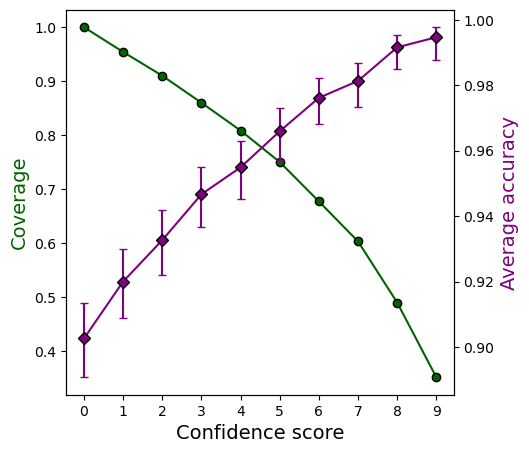

In [43]:
plot_conf_acc_cov_with_CI(
    conf_good_df2,
    #_size = (7.5, 7.5),
    #dpi = 300, out = os.path.join(figs_dir, "ML_conf_cov_acc_good_w_CI.png")
)

In [43]:
conf_good_df1.to_pickle(os.path.join(results_dir, "good_confidence_data.pkl"))
conf_good_df2.to_pickle(os.path.join(results_dir, "good_confidence_data_sum.pkl"))

In [47]:
conf1_rand_f = os.path.join(results_dir, "rand_confidence_data.pkl")
conf2_rand_f = os.path.join(results_dir, "rand_confidence_data_sum.pkl")
if os.path.isfile(conf1_rand_f) and os.path.isfile(conf2_rand_f):
    conf_rand_df1 = pd.read_pickle(conf1_rand_f)
    conf_rand_df2 = pd.read_pickle(conf2_rand_f)
else:
    conf_rand_df1, conf_rand_df2 = get_confidences_df(ann_rand_preds, ann_rand_preds_round, ann_real_vals)

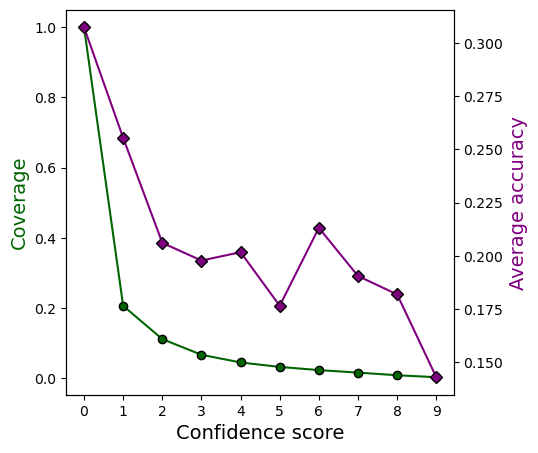

In [48]:
plot_conf_acc_cov(
    conf_rand_df2,
    #f_size = (7.5, 7.5),
    #dpi = 300, out = os.path.join(figs_dir, "ML_conf_cov_acc_rand.png")
)

In [ ]:
conf_rand_df1.to_pickle(os.path.join(results_dir, "rand_confidence_data.pkl"))
conf_rand_df2.to_pickle(os.path.join(results_dir, "rand_confidence_data_sum.pkl"))

## COMPARING CV ACCURACIES ACROSS METHODS AND BASELINES

In [49]:
print("Average 10-repeat 10-fold cross validation for KNN prediction = {}%".format(round(rskf_df.KNN_pred_acc.mean()*100,2)))

print("Average 10-repeat 10-fold cross validation for KNN random prediction = {}%".format(round(rskf_df.KNN_pred_acc_rand.mean()*100,2)))

print("Average 10-repeat 10-fold cross validation for ANN prediction = {}%".format(round(rskf_df.ANN_pred_acc.mean()*100,2)))

print("Average 10-repeat 10-fold cross validation for ANN random prediction = {}%".format(round(rskf_df.ANN_pred_acc_rand.mean()*100,2)))

print("Average 10-repeat 10-fold cross validation for random prediction = {}%".format(round(rskf_df.rand_acc.mean()*100,2)))

Average 10-repeat 10-fold cross validation for KNN prediction = 98.12%
Average 10-repeat 10-fold cross validation for KNN random prediction = 32.65%
Average 10-repeat 10-fold cross validation for ANN prediction = 90.27%
Average 10-repeat 10-fold cross validation for ANN random prediction = 30.73%
Average 10-repeat 10-fold cross validation for random prediction = 24.27%


In [50]:
ANN_pred_acc_mean = rskf_df.ANN_pred_acc.mean()
KNN_pred_acc_mean = rskf_df.KNN_pred_acc.mean()
ANN_pred_acc_rand_mean = rskf_df.ANN_pred_acc_rand.mean()
KNN_pred_acc_rand_mean = rskf_df.KNN_pred_acc_rand.mean()
rand_acc_mean = rskf_df.rand_acc.mean()

ANN_pred_acc_sem = scipy.stats.sem(rskf_df.ANN_pred_acc)
KNN_pred_acc_sem = scipy.stats.sem(rskf_df.KNN_pred_acc)
ANN_pred_acc_rand_sem = scipy.stats.sem(rskf_df.ANN_pred_acc_rand)
KNN_pred_acc_rand_sem = scipy.stats.sem(rskf_df.KNN_pred_acc_rand)
rand_acc_sem = scipy.stats.sem(rskf_df.rand_acc)

In [51]:
print("ANN ", round(ANN_pred_acc_mean*100, 2), round(ANN_pred_acc_sem*100, 2), (round((ANN_pred_acc_mean-ANN_pred_acc_sem)*100, 2), round((ANN_pred_acc_mean+ANN_pred_acc_sem)*100, 2)))

print("KNN ", round(KNN_pred_acc_mean*100, 2), round(KNN_pred_acc_sem*100, 2), (round((KNN_pred_acc_mean-KNN_pred_acc_sem)*100, 2), round((KNN_pred_acc_mean+KNN_pred_acc_sem)*100, 2)))

print("ANN_rand ", round(ANN_pred_acc_rand_mean*100, 2), round(ANN_pred_acc_rand_sem*100, 2), (round((ANN_pred_acc_rand_mean-ANN_pred_acc_rand_sem)*100, 2), round((ANN_pred_acc_rand_mean+ANN_pred_acc_rand_sem)*100, 2)))
KNN_pred_acc_rand_mean
print("KNN_rand ", round(KNN_pred_acc_rand_mean*100, 2), round(KNN_pred_acc_rand_sem*100, 2), (round((KNN_pred_acc_rand_mean-KNN_pred_acc_rand_sem)*100, 2), round((KNN_pred_acc_rand_mean+KNN_pred_acc_rand_sem)*100, 2)))

print("random ", round(rand_acc_mean*100, 2), round(rand_acc_sem*100, 2), (round((rand_acc_mean-rand_acc_sem)*100, 2), round((rand_acc_mean+rand_acc_sem)*100, 2)))

ANN  90.27 0.6 (89.67, 90.87)
KNN  98.12 0.28 (97.85, 98.4)
ANN_rand  30.73 1.08 (29.65, 31.81)
KNN_rand  32.65 0.94 (31.71, 33.59)
random  24.27 0.93 (23.34, 25.2)


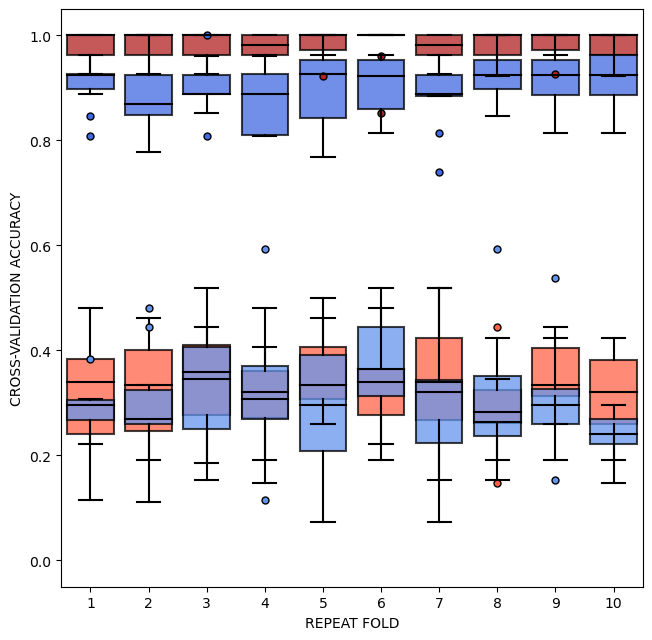

In [52]:
plt.figure(figsize = (7.5, 7.5), dpi = 100)
plt.ylim(-0.05, 1.05)
ax1 = sns.boxplot(y = "KNN_pred_acc", x = "repeat_fold", data = rskf_df, color = "firebrick", **PROPS_pred_KNN, flierprops=flierprops_pred_KNN, saturation = 0.5)
sns.boxplot(y = "ANN_pred_acc", x = "repeat_fold", data = rskf_df, color = "royalblue", **PROPS_pred_ANN, flierprops=flierprops_pred_ANN, saturation = 0.5, ax = ax1)
sns.boxplot(y = "KNN_pred_acc_rand", x = "repeat_fold", data = rskf_df, color = "tomato", **PROPS_rand_KNN, flierprops=flierprops_rand_KNN, saturation = 0.5, ax = ax1)
sns.boxplot(y = "ANN_pred_acc_rand", x = "repeat_fold", data = rskf_df, color = "cornflowerblue", **PROPS_rand_ANN, flierprops=flierprops_rand_ANN, saturation = 0.5, ax = ax1)
#sns.boxplot(y = "rand_acc", x = "repeat_fold", data = rskf_df, color = "gold", **PROPS_rand, flierprops=flierprops_rand)

plt.ylabel("CROSS-VALIDATION ACCURACY")
plt.xlabel("REPEAT FOLD")
#plt.savefig(os.path.join(figs_dir, "ML_CV.png"))
plt.show()

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'ANN_pred_acc'),
  Text(1, 0, 'KNN_pred_acc'),
  Text(2, 0, 'ANN_pred_acc_rand'),
  Text(3, 0, 'KNN_pred_acc_rand'),
  Text(4, 0, 'rand_acc')])

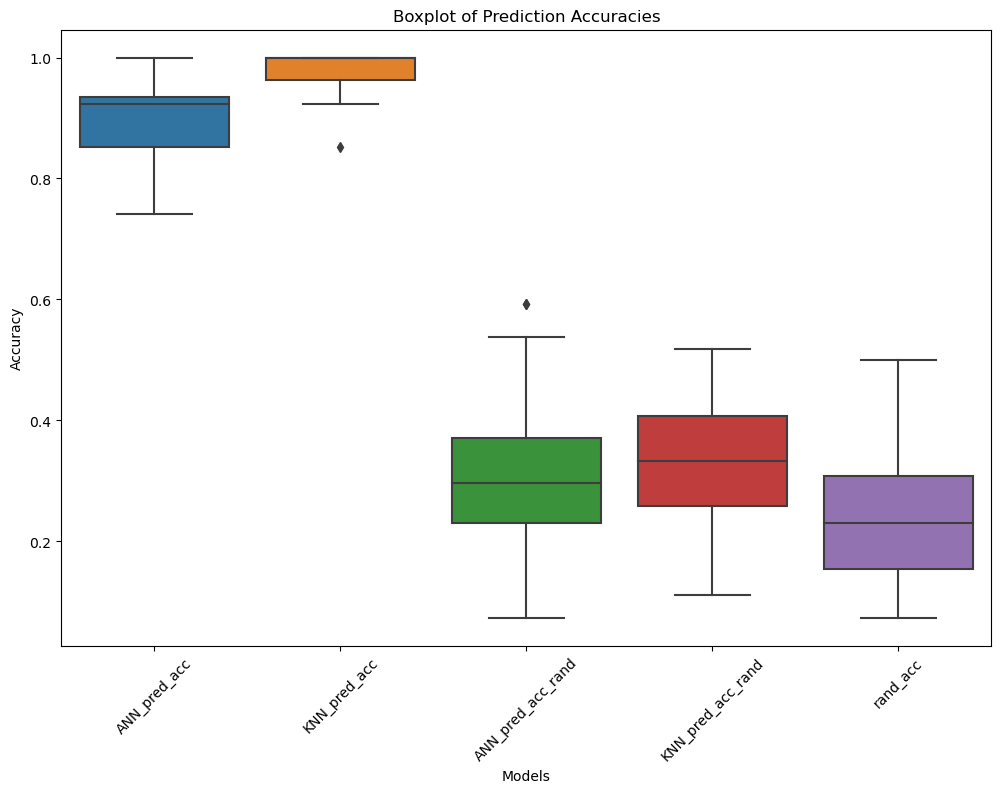

In [14]:
# Now we plot the boxplot using seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(data=rskf_df.drop(columns=['repeat_fold']))
plt.title('Boxplot of Prediction Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.xticks(rotation=45) 

In [16]:
df_melted

,repeat_fold,metrics,values
0,1,ANN_pred_acc,0.925926
1,1,ANN_pred_acc,0.888889
2,1,ANN_pred_acc,0.925926
3,1,ANN_pred_acc,0.962963
4,1,ANN_pred_acc,0.925926
...,...,...,...
495,10,rand_acc,0.333333
496,10,rand_acc,0.346154
497,10,rand_acc,0.500000
498,10,rand_acc,0.230769


In [8]:
rskf_df = rskf_df.rename(columns={
    "ANN_pred_acc": "ANN",
    "KNN_pred_acc": "KNN",
    "ANN_pred_acc_rand": "Random ANN",
    "KNN_pred_acc_rand": "Random KNN",
    "rand_acc": "Random"})

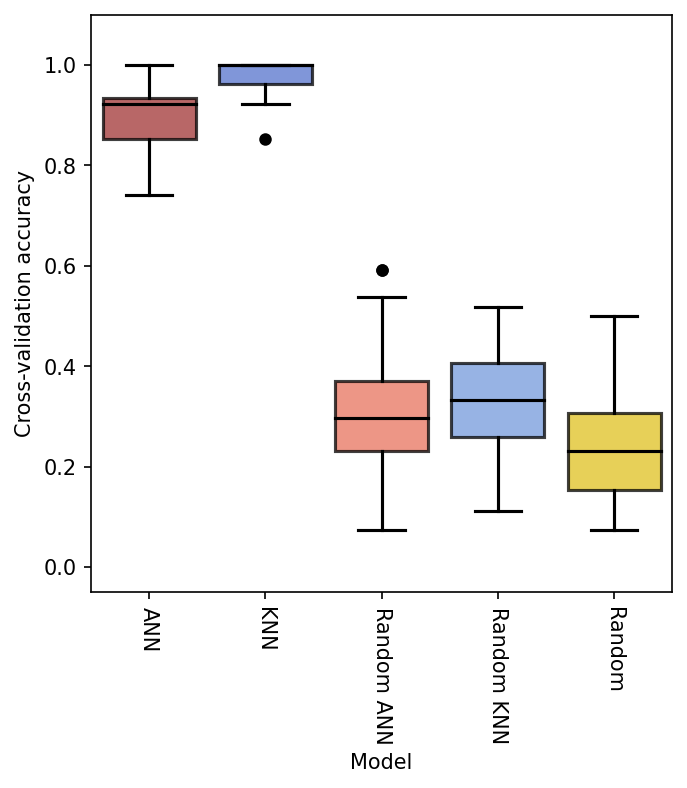

In [12]:
plt.figure(figsize = (5, 5), dpi = 150)

palette = {
    'ANN': 'firebrick',
    'KNN': 'royalblue',
    'Random ANN': 'tomato',
    'Random KNN': 'cornflowerblue',
    'Random': 'gold'
}

alpha = 0.75

PROPS = {
    'boxprops':{'edgecolor':'k', 'alpha' : alpha},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'},
    
}

flierprops = dict(marker='o', markerfacecolor= "k", markersize=5,
                  linestyle='none', color="k", markeredgecolor='k')

# Use the melt function to reshape the DataFrame suitable for sns.boxplot
df_melted = rskf_df.melt(id_vars='repeat_fold', var_name='metrics', value_name='values')

# Create the boxplot with different colors
sns.boxplot(x='metrics', y='values', data=df_melted, palette=palette, **PROPS, flierprops = flierprops)

#sns.violinplot(x='metrics', y='values', data=df_melted, palette=palette, **PROPS, flierprops = flierprops, inner='box', fill = True)

#sns.stripplot(x='metrics', y='values', data=df_melted, palette=palette, size=2, alpha=0.7, edgecolor= "k", linewidth = 1, jitter = True)

#sns.swarmplot(x='metrics', y='values', data=df_melted, palette=palette, size=3, alpha=0.7, edgecolor= "k", linewidth = 1)


plt.ylim(-0.05, 1.1)
plt.ylabel("Cross-validation accuracy")
plt.xlabel("Model")
plt.xticks(rotation=-90)

#plt.savefig(os.path.join(figs_dir, "ML_CV_rev.png"))
plt.show()